In [1]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

# multi-task-gp on the simu data

In [119]:
# load data
data_dict = np.load('../data/simu/simu_data.npy',allow_pickle=True)
data_dict = np.load('../data/simu/simu_data_noise.npy',allow_pickle=True)


x_raw = data_dict.item().get('time_step')
y_raw = data_dict.item().get('data_all')
mask_train = data_dict.item().get('mask_train')

# process to build train/test_x/y, and cooresponding index from the mask

N_f,N = y_raw.shape 
N_train = mask_train[0].sum()
N_test = N-N_train

x_train_list = []
y_train_list = []
x_train_i_list = []


x_test_list = []
y_test_list = []
x_test_i_list = []

for i in range(N_f):
    train_ind = np.argwhere(mask_train[i,:] == True).squeeze()
    test_ind = np.argwhere(mask_train[i,:] == False).squeeze()

    x_train_list.append(x_raw[train_ind])
    x_test_list.append(x_raw[test_ind])

    x_train_i_list.append(np.full(x_raw[train_ind].shape,i))
    x_test_i_list.append(np.full(x_raw[test_ind].shape,i))

    y_train_list.append(y_raw[i,train_ind])
    y_test_list.append(y_raw[i,test_ind])



x_train = torch.from_numpy(np.concatenate(x_train_list)).float() 
x_test = torch.from_numpy(np.stack(x_test_list,1)).float().T

y_train = torch.from_numpy(np.concatenate(y_train_list)).float() 
y_test = torch.from_numpy(np.stack(y_test_list,1)).float().T    

x_train_i = torch.from_numpy(np.concatenate(x_train_i_list))   
x_test_i = torch.from_numpy(np.stack(x_test_i_list,1)).long().T



In [124]:
x_raw.shape
y_raw.shape

(8, 100)

In [120]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=N_f, rank=7)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)



In [121]:
# Find optimal model hyperparameters
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MultitaskGPModel((x_train, x_train_i), y_train, likelihood)
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

MSE = torch.nn.MSELoss()

ITER=200
for i in range(ITER):
    optimizer.zero_grad()
    output = model(x_train, x_train_i)
    loss_mll = -mll(output, y_train)
    loss_mll.backward()
    loss_mse = MSE(output.loc,y_train)
    # loss_mse.backward()
    print('Iter %d/%d - Loss-mll: %.3f, Loss-mse: %.3f' % (i + 1,ITER, loss_mll.item(),loss_mse.item()))
    optimizer.step()

Iter 1/200 - Loss-mll: 1.512, Loss-mse: 0.365
Iter 2/200 - Loss-mll: 1.438, Loss-mse: 0.368
Iter 3/200 - Loss-mll: 1.368, Loss-mse: 0.388
Iter 4/200 - Loss-mll: 1.302, Loss-mse: 0.411
Iter 5/200 - Loss-mll: 1.240, Loss-mse: 0.419
Iter 6/200 - Loss-mll: 1.181, Loss-mse: 0.412
Iter 7/200 - Loss-mll: 1.125, Loss-mse: 0.399
Iter 8/200 - Loss-mll: 1.074, Loss-mse: 0.386
Iter 9/200 - Loss-mll: 1.026, Loss-mse: 0.376
Iter 10/200 - Loss-mll: 0.983, Loss-mse: 0.370
Iter 11/200 - Loss-mll: 0.943, Loss-mse: 0.366
Iter 12/200 - Loss-mll: 0.904, Loss-mse: 0.364
Iter 13/200 - Loss-mll: 0.867, Loss-mse: 0.364
Iter 14/200 - Loss-mll: 0.829, Loss-mse: 0.368
Iter 15/200 - Loss-mll: 0.790, Loss-mse: 0.377
Iter 16/200 - Loss-mll: 0.751, Loss-mse: 0.391
Iter 17/200 - Loss-mll: 0.713, Loss-mse: 0.404
Iter 18/200 - Loss-mll: 0.682, Loss-mse: 0.413
Iter 19/200 - Loss-mll: 0.658, Loss-mse: 0.413
Iter 20/200 - Loss-mll: 0.640, Loss-mse: 0.403
Iter 21/200 - Loss-mll: 0.621, Loss-mse: 0.389
Iter 22/200 - Loss-mll

In [127]:
# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title,test_x,y_true):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')

    # Shade in confidence
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    # ground truth as red line
    ax.plot(x_raw, y_true, 'r')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence','ground-truth'])
    ax.set_title(title)

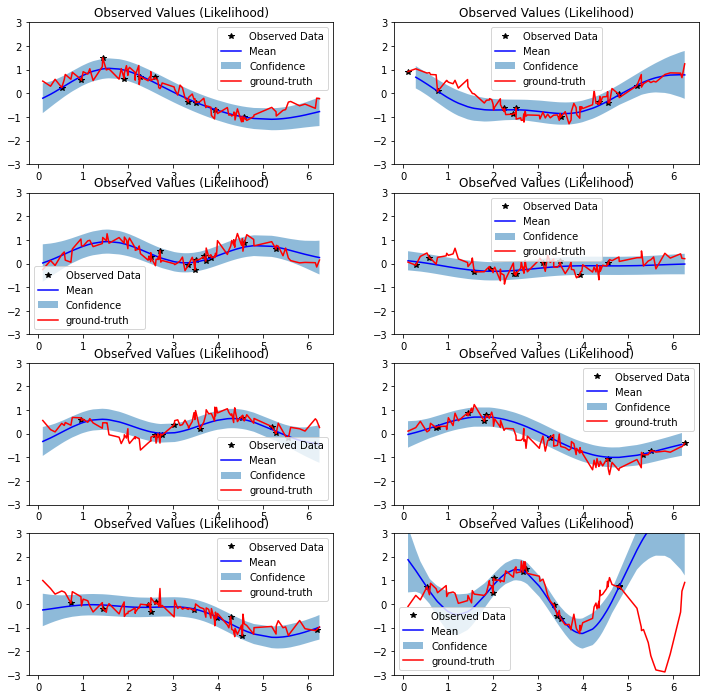

In [128]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, ax_set = plt.subplots(4, 2, figsize=(12,12))

# Test points every 0.02 in [0,1]
test_x1 = x_test[0,:]
test_x2 = x_test[1,:]

test_i_task1 = torch.full((len(test_x1),1), dtype=torch.long, fill_value=0)
test_i_task2 = torch.full((len(test_x2),1), dtype=torch.long, fill_value=1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # observed_pred_y1 = likelihood(model(test_x1, test_i_task1))
    # observed_pred_y2 = likelihood(model(test_x2, test_i_task2))
    
    for i in range(N_f):
        test_data = x_test[i,:]
        test_data_i = x_test_i[i,:]

        train_data = x_train[i*N_train:(i+1)*N_train]
        train_y = y_train[i*N_train:(i+1)*N_train]

        observed_pred_y = likelihood(model(test_data, test_data_i))

        ax_plot(ax_set.flatten()[i], train_y, train_data, observed_pred_y, 'Observed Values (Likelihood)',test_data,y_raw[i])
    
